## Regression

G. Richards (2016,2018), based on materials from Andy Connolly (especially) and Ivezic.

In the simplest form, [**regression**](https://en.wikipedia.org/wiki/Regression_analysis) is about determining the relationship between an independent variable, $x$, and the variable that depends on it, $y$, where the expectation value of $y$ is $E[y|x]$.  In contrast to what we were doing last week, which was largely *unsupervised*, regression is a *supervised* process.

Generally, what we'd like to do is to infer the true pdf from a multi-dimensional sample of data that is drawn from that pdf, using parametric or non-parametric models to do so.  As this is hard, regression seeks to determine the expectation value of $y$ (given $x$) rather than the full pdf.

When I say "regression", you probably think about linear least-squares fitting (fitting a line) or, less likely, maximum likelihood analysis.  However, adopting a Bayesian perspective enables a more physical intuition that includes how we can do regression in the case of both errors and limits on the data. 

You may have heard the term "regression to the mean", which astronomers know all about.  It says that whatever place you decide to build your telescope because it has the best weather, won't have the best weather after you build the telescope!

Let's start by looking at the classic example of fitting a straight line to some data points in 2-D as illustrated by Ivezic, Figure 8.1:

![Ivezic, Figure 8.1a](http://www.astroml.org/_images/fig_linreg_inline_1.png)

Here we have 4 data points $\{x_1,x_2,x_3,x_4\}$ drawn from $y=\theta_1 x + \theta_0$, where $\theta_1 = 1$ and $\theta_0 = 0$.  Each data point provides a joint constraint on $(\theta_0,\theta_1)$.  If there were no uncertainties in the measurement of each $y$, then each new point would yield a straight line constraint in $(\theta_0,\theta_1)$ of 
$\theta_0 = y_i - \theta_1 x_i$.  Think about the constraints from the first point.  You could fit an infinite number of lines through it, all of which would completely cover the $(x,y)$ plane, but those lines only make a line in the $(\theta_0,\theta_1)$ plane.

More data points yield more constraints and the best fit solution would be the intersection of all the lines.  If the measurements have uncertainties associated with them then the lines are linear-shaped distributions as illustrated in the figure below.

![Ivezic, Figure 8.1b](http://www.astroml.org/_images/fig_linreg_inline_2.png)

Below is the code that makes this plot, where I have made the errors really small so that the constraints are now just lines and I added the 4th $x$ value as a point in addition to being a limit so you can see that the excluded region from the limit just follows the line that would result had it been a detection.

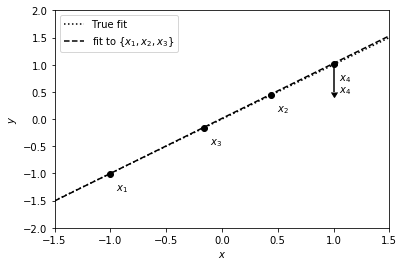

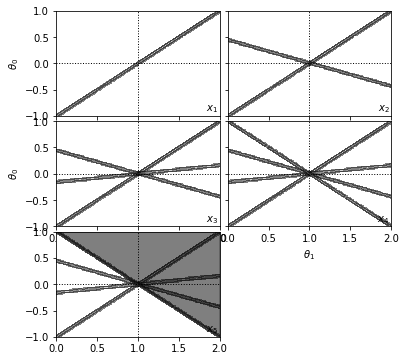

In [1]:
%matplotlib inline
# Ivezic, Figure 8.1
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

#------------------------------------------------------------
# Set up the data and errors
np.random.seed(13)
a = 1
b = 0

#x = np.array([-1, 0.44, -0.16])
x = np.array([-1, 0.44, -0.16, 1.0])
y = a * x + b
#dy = np.array([0.25, 0.22, 0.2])
#dy = np.array([0.01, 0.01, 0.01])
dy = np.array([0.01, 0.01, 0.01, 0.01])

y = np.random.normal(y, dy)

# add a fourth point which is a lower bound
x5 = 1.0
y5 = a * x5 + b + 0.0 

#------------------------------------------------------------
# Compute the likelihoods for each point
a_range = np.linspace(0, 2, 80)
b_range = np.linspace(-1, 1, 80)
logL = -((a_range[:, None, None] * x + b_range[None, :, None] - y) / dy) ** 2
sigma = [convert_to_stdev(logL[:, :, i]) for i in range(4)]

# compute best-fit from first three points
logL_together = logL.sum(-1)
i, j = np.where(logL_together == np.max(logL_together))

amax = a_range[i[0]]
bmax = b_range[j[0]]

#------------------------------------------------------------
# Plot the first figure: the points and errorbars
fig1 = plt.figure(figsize=(6, 4))
ax1 = fig1.add_subplot(111)

# Draw the true and best-fit lines
xfit = np.array([-1.5, 1.5])
ax1.plot(xfit, a * xfit + b, ':k', label='True fit')
ax1.plot(xfit, amax * xfit + bmax, '--k', label='fit to $\{x_1, x_2, x_3\}$')

ax1.legend(loc=2)

ax1.errorbar(x, y, dy, fmt='ok')
ax1.errorbar([x5], [y5], [[0.5], [0]], fmt='_k', uplims=True)

for i in range(4):
    ax1.text(x[i] + 0.05, y[i] - 0.3, "$x_{%i}$" % (i + 1))
ax1.text(x5 + 0.05, y5 - 0.5, "$x_4$")

ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-2, 2)

#------------------------------------------------------------
# Plot the second figure: likelihoods for each point
fig2 = plt.figure(figsize=(6, 6))
fig2.subplots_adjust(hspace=0.05, wspace=0.05)

# plot likelihood contours
for i in range(5):
    ax = fig2.add_subplot(321 + i)
    for j in range(min(i + 1, 4)):
        ax.contourf(a_range, b_range, sigma[j].T,
                    levels=(0, 0.683, 0.955, 0.997),
                    cmap=plt.cm.binary, alpha=0.5)

# plot the excluded area from the fourth point
axpb = a_range[:, None] * x5 + b_range[None, :]
mask = y5 < axpb
fig2.axes[4].fill_between(a_range, y5 - x5 * a_range, 2, color='k', alpha=0.5)

# Label and adjust axes
for i in range(5):
    ax = fig2.axes[i]

    ax.text(1.98, -0.98, "$x_{%i}$" % (i + 1), ha='right', va='bottom')

    ax.plot([0, 2], [0, 0], ':k', lw=1)
    ax.plot([1, 1], [-1, 1], ':k', lw=1)

    ax.set_xlim(0.001, 2)
    ax.set_ylim(-0.999, 1)

    if i in (1, 3):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    if i in (0, 1):
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i in (0, 2):
        ax.set_ylabel(r'$\theta_0$')
    if i in (2, 3):
        ax.set_xlabel(r'$\theta_1$')

plt.show()

## Bayesian Regression
If we take a Bayesian approach to regression, then we write the posterior pdf for the model parameters as:

$$p(\theta|\{x_i, y_i\},I) \propto p(\{x_i,y_i\} | \theta, I) \, p(\theta, I),$$

where $I$ describes the error on the dependent variable.

The likelihood for a single data point can be written as

$$p(y_i|x_i,{\theta}, I) = e(y_i|y)$$

with $e(y_i|y)$ being the probability of getting $y_i$ given the true value of $y$ (i.e. the error distribution). If the error distribution is Gaussian then,

$$p(y_i|x_i,{\theta}, I) = {1 \over \sigma_i \sqrt{2\pi}} \, \exp{\left({-[y_i-f(x_i|{\theta})]^2 \over 2 \sigma_i^2}\right)}.$$

As discussed earlier in the course, when we add points we multiply the likelihood together to improve the constraints.

## 2-D Linear Regression

Let's start with the simplest case: a linear model with independent variable, $x$, and dependent variable, $y$:
$$y_i = \theta_0 + \theta_1 x_i + \epsilon_i,$$
where $\theta_0$ and $\theta_1$ are the coefficients of the model that we are trying to estimate and $\epsilon_i$ is an additive noise term.

If the uncertainties can be characterized by $\epsilon_i = \mathscr{N}(0,\sigma_i)$, then, following from above, the likelihood is

$$p(\{y_i\}|\{x_i\},{\theta}, I) \propto \prod_{i=1}^N \exp \left(\frac{-(y_i- (\theta_0 + \theta_1x_{i}))^2}{  2\sigma_i^2}\right).$$

For linear regression the log likelihood (assuming a flat/uninformative prior) is then

$$\ln \mathcal(L) \equiv \ln(p({\theta}|\{x_i, y_i\},I))  \propto \sum_{i=1}^N \left(\frac{-(y_i- (\theta_0 + \theta_1x_{i}))^2}{  2\sigma_i^2}\right).$$

Maximizing this expression is the same as minimizing the least squares. 

For so-called "homoscedastic" errors (errors that are the same for all points, or rather that the error on the model is the same), this minimization yields to
$$\theta_1 = \frac{\sum_i^N x_i y_i - \bar{x}\bar{y}}{\sum_i^N(x_i-\overline{x})^2},$$
and
$$\theta_0 = \overline{y} - \theta_1\overline{x},$$
where $\overline{x}$ and $\overline{y}$ are the mean values.

The estimate of the variance and the standard errors of the estimated parameters are
$$\sigma^2 = \sum_{i=1}^N (y_i - \theta_0 + \theta_1 x_i)^2,$$

$$\sigma_{\theta_1}^2 = \sigma^2\frac{1}{\sum_i^N(x_i-\overline{x})^2},$$

$$\sigma_{\theta_0}^2 = \sigma^2\left(\frac{1}{N} + \frac{\overline{x}^2}{\sum_i^N(x_i-\overline{x})^2}\right).$$


If the errors are instead heteroscedastic (error not the same for all points), or just more generally, it is better to think of the problem in matrix notation:
$$Y= M \theta$$

$Y$ is an $N$-dimensional vector of values ${y_i}$,
$$Y=\left[
\begin{array}{c}
y_0\\
.\\
y_{N-1}
\end{array}
\right].
$$

For the straight line $\theta$ is simply a two-dimensional
vector of regression coefficients,
$$
\theta=\left[
\begin{array}{c}
\theta_0\\
\theta_1
\end{array}
\right],
$$

and $M$ is a called the design matrix
$$
M=\left[
\begin{array}{cc}
1 & x_0\\
.&.\\
1&x_{N-1}
\end{array}
\right],
$$

where the constant in the first column of $M$ captures the zeropoint in the regression.

For heteroscedastic uncertainties we can define a ($N\times N$) covariance matrix
$$C=\left[
\begin{array}{cccc}
\sigma_{0}^2 & 0 & . & 0 \\
. & . & . & . \\
0 & 0 & . & \sigma_{N-1}^2 \\
\end{array}
\right]
$$
and the maximum likelihood solution for the regression is
$$\theta = (M^T C^{-1} M)^{-1} (M^T C^{-1} Y),$$

which minimizes the sum of squares and gives uncertainties on $\theta$ of 
$$\Sigma_\theta =
\left[
\begin{array}{cc}
\sigma_{\theta_0}^2 & \sigma_{\theta_0\theta_1} \\
\sigma_{\theta_0\theta_1} & \sigma_{\theta_1}^2
\end{array}
\right]
= [M^T C^{-1} M]^{-1}.
$$

With numpy it is straightforward to develop matrices and, as long as they can be inverted, calculate the  regression coefficients.

Below is the first panel of Figure 8.2, where we have done a straight-line regression to data with a non-linear correlation.  

These are redshifts to Supernovae and so-called "distance moduli".  Knowing the relationship between these gives us the parameters that describe things like the expansion rate of the Universe.

A reminder on nomenclature for Scikit-Learn: $X$ is the multidimensional matrix of $N$ "objects", each with $K$ attributes.  $y$ is the dependent variable that represents a continuous "truth" value for each of those $N$ objects.  What is new here is that are adding $dy$, which is the uncertainty on $y$.  The fitting algorithms are going to be of the form:

```model.fit(X,y,dy)```.

[39.68715333  4.62320027]


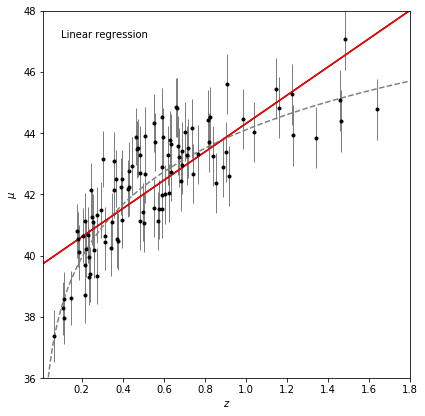

In [84]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression, PolynomialRegression, BasisFunctionRegression, NadarayaWatson

#------------------------------------------------------------
# Generate data: redshift, distance modulus and error on the distance modulus
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000) # "x" values
mu_true = np.array([x for x in map(cosmo.mu, z)])  # Ground truth y values
n_constraints = 2

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, hspace=0.05, wspace=0.05)

#fit data using the design matrix formalism
C = np.identity(len(z_sample))*(dmu*dmu)
M = np.column_stack((np.ones(len(z_sample)),z_sample))
A = np.dot(np.dot(M.transpose(),np.linalg.pinv(C)),M)
B = np.dot(np.dot(M.transpose(),np.linalg.pinv(C)),mu_sample)

theta = np.dot(np.linalg.pinv(A),B)
print(theta)
mu_out = theta[0] + theta[1]*z 

#fit data using standard package
LRmodel = LinearRegression()
LRmodel.fit(z_sample[:, None], mu_sample, dmu)
mu_fit = LRmodel.predict(z[:, None])
mu_sample_fit = LRmodel.predict(z_sample[:, None])
chi2_dof = (np.sum(((mu_sample_fit - mu_sample)/dmu)**2)/(len(mu_sample) - n_constraints))

#plot the data
ax = fig.add_subplot(111)
ax.plot(z, mu_fit, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

#ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof, ha='center', va='bottom', transform=ax.transAxes, fontsize=14)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)
ax.text(0.05, 0.95, 'Linear regression', ha='left', va='top',
                transform=ax.transAxes)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

ax.plot(z, mu_out, '-k', color='red')

plt.show()

Print $C$, $M$, $A$, $B$, and $\theta$ and make sure that you understand how these are constructed.

Then compare `mu_out` to `mu_fit`.

In [85]:
#print(mu_out-mu_fit)
#plt.hist(mu_out-mu_fit)
print(C)

[[0.90699676 0.         0.         ... 0.         0.         0.        ]
 [0.         0.9329001  0.         ... 0.         0.         0.        ]
 [0.         0.         0.91516301 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.75956268 0.         0.        ]
 [0.         0.         0.         ... 0.         0.95386457 0.        ]
 [0.         0.         0.         ... 0.         0.         0.71771397]]


So, what we did was to replace
```
C = np.identity(len(z_sample))*(dmu*dmu)
M = np.column_stack((np.ones(len(z_sample)),z_sample))
A = np.dot(np.dot(M.transpose(),np.linalg.pinv(C)),M)
B = np.dot(np.dot(M.transpose(),np.linalg.pinv(C)),mu_sample)
theta = np.dot(np.linalg.pinv(A),B)
mu_out = theta[0] + theta[1]*z 
```

with
```
LRmodel = LinearRegression()
LRmodel.fit(z_sample[:, None], mu_sample, dmu)
mu_fit = LRmodel.predict(z[:, None])
```

### A Word of Caution

[Anscombe's Quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) is a demonstration of why you should always visualize your data and not just blindly use the parameters of some black-box fitting algorithm.

![Anscombe's Quartet](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Anscombe%27s_quartet_3.svg/1000px-Anscombe%27s_quartet_3.svg.png)

Each of these data sets has 11 points and basic statistical properties that are identical.

## Multivariate regression

In the above cases, we were doing 2-D linear regression with a univariate $X$.  If $X$ is instead multivariate, then we fit a hyperplane rather than a straight line

$$y_i =\theta_0 + \theta_1x_{i1} + \theta_2x_{i2} + \cdots +\theta_kx_{ik} + \epsilon_i.$$
 
The design matrix, $M$, is now 
$$M = \left(
\begin{array}{ccccccc}
1 & x_{01} & x_{02} & . & x_{0k}\\
1 & x_{11} & x_{12} & . & x_{1k}\\
. & . & . & .  & . \\
1 & x_{N1} & x_{N2} & . & x_{Nk}\\
\end{array}
\right)$$
but the whole formalism is the same as before.

Scikit-Learn obviously has a [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) routine, but it does not explicitly account for heteroscedastic errors, so above we used the AstroML routine instead as illustrated below.

In [86]:
import numpy as np
from astroML.linear_model import LinearRegression
X = np.random.random((100,2)) # 100 points in 2D
dy = np.random.random(100) # heteroscedastic errors
y = np.random.normal(X[:,0] + X[:,1],dy)
model = LinearRegression()
model.fit(X,y,dy)
y_pred = model.predict(X)

## Polynomial Regression

We introduced regression with examples of linear regression, but we can think of it more generically in terms of [polynomical regression](https://en.wikipedia.org/wiki/Polynomial_regression) with $y=f(x|\theta)$ and
$$y_i =\theta_0 + \theta_1 x_{i} + \theta_2 x_{i}^2 + \cdots +\theta_3 x_{i}^3 + \cdots,$$
where linear regression is the simplified case where we just take the first 2 terms.
 
For polynomical regression the design matrix, $M$, is now
 
$$M = \left(
\begin{array}{cccccc}
1 & x_{0} & x_{0}^2 & x_{0}^3\\
1 & x_{1} & x_{1}^2 & x_{1}^3\\
. & . & . & . \\
1 & x_{N} & x_{N}^2 & x_{N}^3\\
\end{array}
\right).$$

As with linear regression, we'll use PolynomialRegression from AstroML.

In [87]:
#Typical call
import numpy as np
from astroML.linear_model import PolynomialRegression
X = np.random.random((100,2))
y = X[:,0]**2 + X[:,1]**3
order = 4
model = PolynomialRegression(order) # fit 3rd order polynomial
model.fit(X,y)
y_pred = model.predict(X)
n_constraints = order+1

Recreate the supernovae figure from above now using the `PolynomialRegression` algorithm with `order=4`  (Hint: Don't overthink it.)

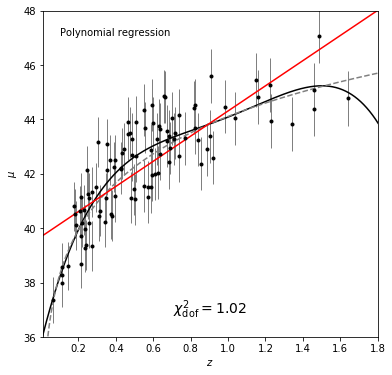

In [88]:
#fit data using standard package
order = 4 
n_constraints = order+1
poly = PolynomialRegression(order)
poly.fit(z_sample[:,None], mu_sample, dmu)
mu_fit = poly.predict(z[:,None])
mu_sample_fit = poly.predict(z_sample[:,None])
chi2_dof = (np.sum(((mu_sample_fit - mu_sample)/dmu)**2)/(len(mu_sample) - n_constraints))

fig = plt.figure(figsize=(6, 6))

#plot the data
ax = fig.add_subplot(111)
ax.plot(z, mu_fit, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
    ha='center', va='bottom', transform=ax.transAxes, fontsize=14)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)
ax.text(0.05, 0.95, 'Polynomial regression', ha='left', va='top',
                transform=ax.transAxes)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')
ax.plot(z, mu_out, '-k', color='red')
plt.show()

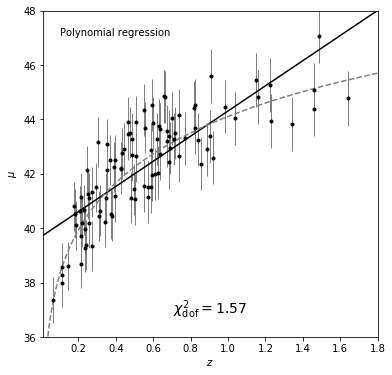

In [89]:
#fit data using standard package
order = 1 
n_constraints = order+1
poly = PolynomialRegression(order)
poly.fit(z_sample[:,None], mu_sample, dmu)
mu_fit = poly.predict(z[:,None])
mu_sample_fit = poly.predict(z_sample[:,None])
chi2_dof = (np.sum(((mu_sample_fit - mu_sample)/dmu)**2)/(len(mu_sample) - n_constraints))

fig = plt.figure(figsize=(6, 6))

#plot the data
ax = fig.add_subplot(111)
ax.plot(z, mu_fit, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
    ha='center', va='bottom', transform=ax.transAxes, fontsize=14)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)
ax.text(0.05, 0.95, 'Polynomial regression', ha='left', va='top',
                transform=ax.transAxes)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')
#ax.plot(z, mu_out, '-k', color='red')
plt.show()

Can you make the same code do linear regression?

## Basis function regression

If we consider a function in terms of the sum of bases (this can be polynomials, Gaussians, quadratics, cubics) then we can solve for the coefficients using regression. Above we have used polynomials,  but we could substitute $x_{0}^2$ etc for Gaussians (where we fix $\sigma$ and $\mu$ and fit for the amplitude) as long as the attribute we are fitting for is linear.  So if linear regression is just a special case of polynomial regression, then polynomial regression is just a special case of basis function regression.

In [90]:
#Basis function regression looks like this
import numpy as np
from astroML.linear_model import BasisFunctionRegression
X = np.random.random((100,1))
y = np.random.normal(X[:,0],dy)
mu = np.linspace(0,1,10)[:, None]
sigma = 0.1
model = BasisFunctionRegression('gaussian', mu=mu, sigma=sigma)
model.fit(X,y,dy)
y_pred = model.predict(X)

We'll now repeat the supernova data example using basis function regression.

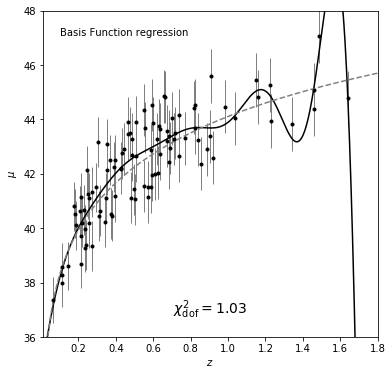

In [91]:
#------------------------------------------------------------
# Define our Gaussians
nGaussians = 10
basis_mu = np.linspace(0,2,nGaussians)[:, None]
basis_sigma = 1.0 * (basis_mu[1] - basis_mu[0])
n_constraints = nGaussians+1

#fit data using gaussian-based basis function regression
bfr = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
bfr.fit(z_sample[:, None], mu_sample, dmu)
mu_fit = bfr.predict(z[:, None])
mu_sample_fit = bfr.predict(z_sample[:, None])
chi2_dof = (np.sum(((mu_sample_fit - mu_sample) / dmu) ** 2) / (len(mu_sample) - n_constraints))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111)

ax.plot(z, mu_fit, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
    ha='center', va='bottom', transform=ax.transAxes, fontsize=14)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)
ax.text(0.05, 0.95, 'Basis Function regression', ha='left', va='top',
                transform=ax.transAxes)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

#ax.plot(z, mu_out, '-k', color='red')
plt.show()

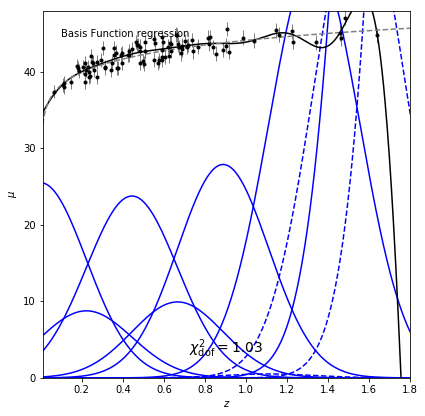

In [92]:
# Do it by hand so that we can overplot the Gaussians

def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

#------------------------------------------------------------
M = np.zeros(shape=[nGaussians, z_sample.shape[0]])
for i in range(nGaussians):
    M[i] = gaussian_basis(z_sample, basis_mu[i], basis_sigma)

M = np.matrix(M).T
C = np.matrix(np.diagflat(dmu**2))
Y = np.matrix(mu_sample).T
coeff = (M.T * C.I * M).I * (M.T * C.I * Y)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, hspace=0.05, wspace=0.05)

ax = fig.add_subplot(111)

# Plot the gaussians and their sum
i=0
mu_fit = np.zeros(len(z))   
for i in range(nGaussians):
    mu_fit += coeff[i,0]*gaussian_basis(z, basis_mu[i], basis_sigma)
    if (coeff[i,0] > 0.):
        ax.plot(z,coeff[i,0]*gaussian_basis(z, basis_mu[i], basis_sigma),color='blue')
    else:
        ax.plot(z,-coeff[i,0]*gaussian_basis(z, basis_mu[i], basis_sigma),color='blue',ls='--')

#plot the data
ax.plot(z, mu_fit, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
    ha='center', va='bottom', transform=ax.transAxes, fontsize=14)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(0.01, 48)
ax.text(0.05, 0.95, 'Basis Function regression', ha='left', va='top',
                transform=ax.transAxes)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

#ax.plot(z, mu_out, '-k', color='red')
plt.show()

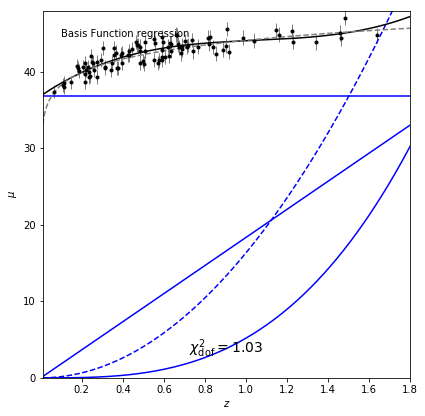

In [93]:
# GTR: Hacked the above to make the basis a polynomial just to show
# that polynomial regression is a special case of basis function regression

#------------------------------------------------------------
# Define our "Gaussians" (order or polynomial in this case)
nGaussians = 4
basis_mu = np.linspace(0,2,nGaussians)[:, None]
basis_sigma = 1.0 * (basis_mu[1] - basis_mu[0])
n_constraints = nGaussians+1

def gaussian_basis(n, x, mu, sigma):
    return x**n

#------------------------------------------------------------
M = np.zeros(shape=[nGaussians, z_sample.shape[0]])
for i in range(nGaussians):
    M[i] = gaussian_basis(i, z_sample, basis_mu[i], basis_sigma)

M = np.matrix(M).T
C = np.matrix(np.diagflat(dmu**2))
Y = np.matrix(mu_sample).T
coeff = (M.T * C.I * M).I * (M.T * C.I * Y)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, hspace=0.05, wspace=0.05)

ax = fig.add_subplot(111)

# Plot the gaussians and their sum
i=0
mu_fit = np.zeros(len(z))   
for i in range(nGaussians):
    mu_fit += coeff[i,0]*gaussian_basis(i,z, basis_mu[i], basis_sigma)
    if (coeff[i,0] > 0.):
        ax.plot(z,coeff[i,0]*gaussian_basis(i,z, basis_mu[i], basis_sigma),color='blue')
    else:
        ax.plot(z,-coeff[i,0]*gaussian_basis(i,z, basis_mu[i], basis_sigma),color='blue',ls='--')

#plot the data
ax.plot(z, mu_fit, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
    ha='center', va='bottom', transform=ax.transAxes, fontsize=14)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(0.01, 48)
ax.text(0.05, 0.95, 'Basis Function regression', ha='left', va='top',
                transform=ax.transAxes)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

#ax.plot(z, mu_out, '-k', color='red')
plt.show()

Can similarly think of regular linear regression like this.  Just end up with zeros for most of the line coefficients.

## Kernel Regression

In the case of Gaussian Basis Regression, if you think about it, we were back to the old problem of making a histogram.  Specifically, our Gaussians were evenly spaced over the range of interest.   If we instead placed Gaussians at the location of every data point, we get Gaussian Kernel Regression instead.  Or just [Kernel Regression](https://en.wikipedia.org/wiki/Kernel_regression) more generally since we don't *have* to have a Gaussian kernel function.  It is also called Nadaraya-Watson regression.


Given a kernel $K(x_i,x)$ (e.g. a Gaussian or top-hat) at each point we estimate the function value by

$$f(x|K) = \frac{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right) y_i}
{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right)}$$

a weighted average of $y$ (weighted by distance) with

$$w_i(x) = \frac{ K\left( \frac{||x_i-x||}{h} \right)}
{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right)}$$

This locally weighted regression technique drives the regressed value to the nearest neighbor (when we have few points) which helps with extrapolation issues.  As we saw with KDE, defining the correct bandwidth of the kernel is more important than the shape of the kernel itself and is done through cross-validation, which we'll talk about next time.

Nadaraya-Watson is implemented in AstroML as follows:

In [94]:
import numpy as np
from astroML.linear_model import NadarayaWatson
X = np.random.random((100,2))
y = X[:,0] + X[:,1]
model = NadarayaWatson('gaussian', 0.05)
model.fit(X,y)
y_pred = model.predict(X)

Using Nadaraya-Watson on our supernova data looks like this:

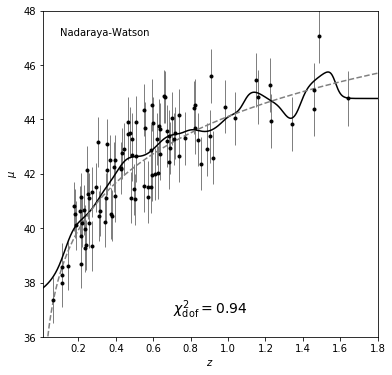

In [96]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
from astroML.linear_model import NadarayaWatson

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.array([x for x in map(cosmo.mu, z)])

n_constraints = 1

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111)

#fit data using standard package
nwreg = NadarayaWatson('gaussian',0.05)
nwreg.fit(z_sample[:, None], mu_sample)
mu_sample_fit = nwreg.predict(z_sample[:, None])
mu_fit = nwreg.predict(z[:, None])
chi2_dof = (np.sum(((mu_sample_fit - mu_sample) / dmu) ** 2)/(len(mu_sample) - n_constraints))


#plot the data
ax.plot(z, mu_fit, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
    ha='center', va='bottom', transform=ax.transAxes, fontsize=14)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)
ax.text(0.05, 0.95, 'Nadaraya-Watson', ha='left', va='top',
                transform=ax.transAxes)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

#ax.plot(z, mu_out, '-k', color='red')

plt.show()

## Regularization

We have to be a little careful when doing regression because if we progressively increase the number of terms in the fit then  we reach a regime where we are overfitting the data (i.e. there are not enough degrees of freedom).

For example, let's look at an example of Polynomial Regression.  

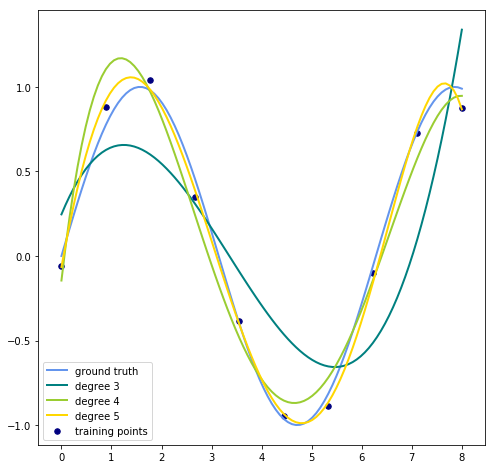

In [97]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astroML.linear_model import PolynomialRegression

orders=[3,4,5]

def f(x):
    """ function to approximate by polynomial interpolation"""
    return np.sin(x)

# generate points used to plot
x_plot = np.linspace(0, 8, 100)

# generate points and keep a subset of them
x = np.linspace(0, 8, 10)
#rng = np.random.RandomState(0)
#rng.shuffle(x)
#x = np.sort(x[:10])
y = f(x)+0.25*(np.random.random(len(x))-0.5)

# create matrix versions of these arrays
X = x[:, None]
X_plot = x_plot[:, None]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.figure(figsize=(8,8))
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw, label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate(orders):
    poly = PolynomialRegression(degree)
    poly.fit(X,y)
    y_plot = poly.predict(X_plot)

    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw, label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

This is fit with order = 3, 4, and 5.  What happens if you make the order $\sim N_{\rm points}$?

In that case we are clearly overfitting the data.  For cases where we are concerned with overfitting, instead of computing 

$$(Y - M \theta)^T(Y- M \theta),$$

we can apply constraints (usually of smoothness, number of coefficients, size of coefficients):

$$(Y - M \theta)^T(Y- M \theta) + \lambda |\theta^T \theta|,$$

with $\lambda$ as the "regularization parameter".

This leads to a solution for the parameters of the model

$$\theta = (M^T C^{-1} M + \lambda I)^{-1} (M^T C^{-1} Y)$$

with $I$ the identity matrix.

From the Bayesian perspective this is the same as applying a prior to the regression coefficients:

$$p(\theta | I ) \propto \exp{\left(\frac{-(\lambda \theta^T \theta)}{2}\right)}$$

which, when multiplied by the likelihood for regression, gives the same posterior as described above.

## Ridge regression 

The case for a Gaussian prior corresponds to [Ridge Regression](https://en.wikipedia.org/wiki/Tikhonov_regularization), which
penalizes the regression coefficients according to

$$ |\theta |^2 < s.$$

That is the square of each parameter in the fitting is restricted to be less than some value, $s$.  We'll come back to exactly what $s$ is in a minute.  Doing this supresses large coefficients and limits the variance of the system---at the cost of increased bias.

The following figure illustrates the interaction of the prior and the posterior without the prior:
![Ivezic, Figure 8.3](http://www.astroml.org/_images/fig_lasso_ridge_1.png)

Scikit-Learn's [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) is their implementation of ridge regression, while AstroML implements Ridge Regression as follows:

In [98]:
import numpy as np
from sklearn.linear_model import Ridge
X = np.random.random((100,10))
y = np.dot(X, np.random.random(10))
model = Ridge(alpha=0.05)
model.fit(X,y)
y_pred = model.predict(X)

The following examples compares Gaussian Basis Regression with and without the constraints from Ridge Regression.  It uses 100 evenly spaced Gauassians, which we can see strongly overfits the problem and has very large coefficient values, until a constraint is imposed.

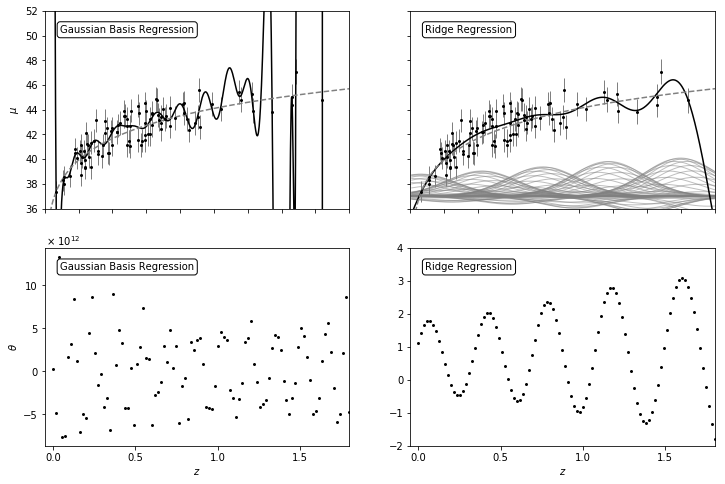

In [100]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# generate data
np.random.seed(0)
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)
cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu = np.array([x for x in map(cosmo.mu, z)])

#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 1.8, 100)
widths = 0.2
X = gaussian_basis(z_sample[:, None], centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(12, 8))

classifier = [LinearRegression, Ridge]
kwargs = [dict(), dict(alpha=0.005)]
labels = ['Gaussian Basis Regression', 'Ridge Regression']

for i in range(2):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))

    # plot fit
    ax = fig.add_subplot(221 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)

    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(223 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

plt.show()

## Least absolute shrinkage and selection (LASSO) regularization

An alternative to Ridge Regression is LASSO, which implies the following contraint

$$(Y - M \theta)^T(Y- M \theta) + \lambda |\theta|.$$

This is equivalent to least-squares minimization with 
$$ |\theta | < s,$$
that is, the penalty is on the absolute values of the regression coefficients, which is also illustrated in Ivezic, Figure 8.3 as shown above.

It not only weights the regression coefficients, it also imposes sparsity on the regression
model (i.e. the penalty preferentially selects regions of likelihood space that coincide with one of the vertices within the region defined by the regularization).

This has the effect of setting one (or more) of the model attributes to zero.  

[Scikit-Learn's `LASSO`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is implemented as follows:

In [101]:
import numpy as np
from sklearn.linear_model import Lasso
XX = np.random.random((100,10))
yy = np.dot(XX, np.random.random(10))
model = Lasso(alpha = 0.05)
model.fit(XX,yy)
y_pred = model.predict(XX)

Modify the code above to replace Ridge regression with Lasso regression.  Experiment with different values of the regularization parameter.

N.B.  $\lambda$ in the book is related to $\alpha$ in these examples, but I'm not sure if they are identical.

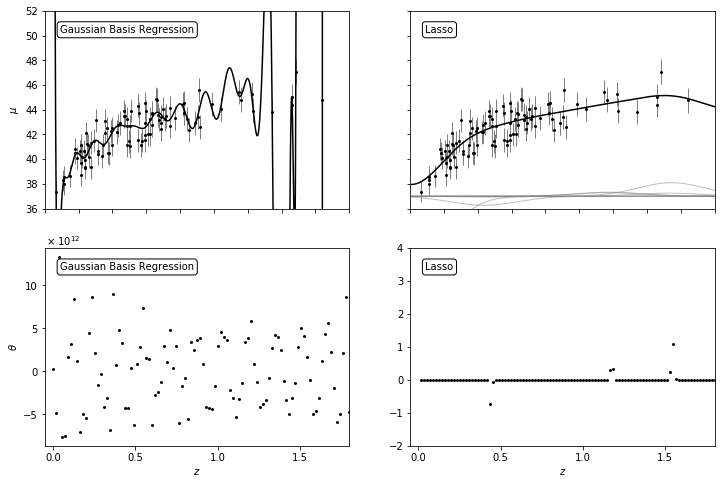

In [102]:
#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(12, 8))

classifier = [LinearRegression, Lasso]
kwargs = [dict(), dict(alpha=0.005)]
labels = ['Gaussian Basis Regression', 'Lasso']

for i in range(2):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))

    # plot fit
    ax = fig.add_subplot(221 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)

    ax.plot(z, fit, '-k')
    #ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(223 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

plt.show()

Did you try `alpha=0`?  If not, go ahead and do that.  

Are you totally confused?  Don't worry, it is much simpler than it seems.  I found [Hastie](http://statweb.stanford.edu/~tibs/ElemStatLearn/index.html) to be helpful in sorting this out. 

They write the constraint term as 
$$\lambda \sum_{j=1}^p |\theta_j|^q,$$
which allows us to see that Ridge regression corresponds to $q=2$, while LASSO regression corresponds to $q=1$.  So, they are really the same thing: Bayes estimates with different priors.   The wildly different names are just a nuisance.

Now let's see if we can understand what is going on in Ivezic, Figure 8.3.

Think of $s$ as a normalized distance where $s=1$ corresponds to there being no constraint on $\theta_i$.  Requiring $s<1$ limits the magnitude of $\theta_i$.  So, in this figure
![Ivezic, Figure 8.3](http://www.astroml.org/_images/fig_lasso_ridge_1.png)
$s=1$ would make the circle/diamond big enough to include what they call $\theta_{\rm normal}$.  

It isn't obvious to me, but I guess that the $\theta_i$ are normalized such that the contraint region is symmetric.  

Shrinking $s$ has the effect of adding a prior that moves the best-fit parameters to the intersection of the two sets of contours.  The difference between Ridge and LASSO is just the shape of the constraint region.  For LASSO, the shape is such that some of the parameters may end up being 0.  

Figures 3.8 (page 84 of the [Hastie PDF](http://statweb.stanford.edu/~tibs/ElemStatLearn/index.html)), 3.10 (page 89), and 3.12 (page 91) may be helpful.

### How do we choose $\lambda$?

Use cross-validation (see next lecture).





Let's practice using the [Boston Housing data](http://scikit-learn.org/stable/datasets/index.html#boston-house-prices-dataset).  

This data set contains 12 attributes that can be used to predict the price of houses in Boston.  Because the attributes (columns of $X$) are inhomogenous, some may be more relevant than others.  So LASSO might be a good thing to try in such situations.

In [103]:
#Execute this cell to read in the data
#Also identify the index of the "Number of Rooms" attribute
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.feature_names)
RMindex = np.argwhere(boston.feature_names=="RM")[0,0]
print(RMindex)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
5


In [104]:
print(2/3*10)

6.666666666666666


Start by looking at just how the number of rooms predicts the price.

In [105]:
X_RM = boston.data[:,RMindex][:,None]
y = boston.target

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_RM, y)
print(reg.coef_, reg.intercept_)

[9.10210898] -34.67062077643857


(0, 52)

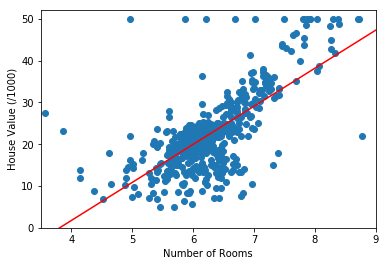

In [106]:
import matplotlib.pyplot as plt
plt.scatter(X_RM,y)
plt.xlabel("Number of Rooms")
plt.ylabel("House Value (/1000)")

Xgrid = np.linspace(1,9,9)
ypred = reg.intercept_ + Xgrid*reg.coef_[0]
plt.plot(Xgrid,ypred,c='r')
plt.xlim(3.5,9)
plt.ylim(0,52)
plt.show()

Now use all attributes, first with `LinearRegression`.  Then with LinearRegression again, but with the data scaled using `StandardScaler` from `sklearn.preprocessing` (since the features are very heterogeneous).  Then fit the scaled data agin with LASSO to see which features aren't that important.  We'll plot the coefficients of each.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

X = boston.data
y = boston.target

scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

linreg = LinearRegression().fit(X,y)
linreg_scaled = LinearRegression().fit(___,y)
lasso_scaled = Lasso(alpha=0.5).fit(___,___)

print(linreg.coef_, linreg.intercept_)
print(linreg_scaled.coef_, linreg_scaled.intercept_)
print(lasso_scaled.coef_, lasso_scaled.intercept_)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5)) 
plt.subplots_adjust(hspace=0.001)

x_pos = np.arange(len(boston.feature_names))

for i in range(3):
    # plot theta
    ax = plt.subplot(311 + i)
    ax.set_ylabel(r'$\theta$')

    ax.set_xticks(x_pos)
    if i == 2:
        ax.set_xticklabels(boston.feature_names, rotation=60)     
    else: 
        ax.set_xticklabels([])
    
    ax.set_xlim(-0.5, 12.5)
 
    if i == 0:
        ax.bar(x_pos, linreg.coef_, alpha=0.5, label="LinReg")
        #ax.set_ylim(-2, 4)
        plt.legend(loc=4)
    elif i == 1:
        ax.bar(x_pos, linreg_scaled.coef_, alpha=0.5, label="LinRegScaled")
        #ax.set_ylim(-2, 4)
        plt.legend(loc=1)
    elif i == 2:
        ax.bar(x_pos, lasso_scaled.coef_, alpha=0.5, label="LASSO")
        #ax.set_ylim(-0.5, 2)
        plt.legend()

Note that NOX had a large coefficient (because is factor of 10 smaller than RM), but isn't particularly relevant.  So, should probably scale the data first.